## In this notebook we are going to extract different subtopics from quotes using different methods.
## Extract Subtopic

In [120]:
import nltk
from nltk.corpus import wordnet as wn
from nltk import word_tokenize, pos_tag
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt


import sys
from wordcloud import WordCloud
#sys.path.append("https://raw.githubusercontent.com/Azri-oss/Social_Graphs_Assignment_1/main/Assignment_2/libs/backboning.py")

sys.path.append("C:\\Users\\antoi\\Documents\\GitHubPerso\\Social_Graphs_Assignment_1\\Project\\libs")
import backboning

folder_name = "C:\\Users\\antoi\\Documents\\GitHubPerso\\Social_Graphs_Assignment_1\\Project"

Load Quotes

In [ ]:
name_subject = "Art"

with open(folder_name + "\\" + name_subject + "_quotes.txt", "r", encoding="utf-8") as f:
    quotes = [line.strip() for line in f.readlines() if line.strip()]
print(f"Total quotes loaded: {len(quotes)}")


Total quotes loaded: 321


### Try using Wordnet

In [156]:
def extract_subtopics(quote):
    tokens = word_tokenize(quote)
    tagged = pos_tag(tokens)

    subtopics = []

    for word, tag in tagged:
        if tag.startswith("N") or tag.startswith("J"):  # noun or adj
            synsets = wn.synsets(word)
            if synsets:
                hypernyms = synsets[0].hypernyms()
                if hypernyms:
                    subtopics.append(hypernyms[0].lemma_names()[0])
                    
    return list(set(subtopics))


Create a graph : edge between two quotes having subtopics in common

In [157]:
G = nx.Graph()
iteration = 0
for quote in quotes:
    iteration += 1
    subtopics = extract_subtopics(quote)
    G.add_node(quote, subtopics=subtopics)
    #if iteration < 10:
        #print(f"Quote: {quote}\nSubtopics: {subtopics}\n")

In [158]:
# Add edges based on common subtopics
for i in range(len(quotes)):
    for j in range(i + 1, len(quotes)):
        q1, q2 = quotes[i], quotes[j]
        
        sub1 = set(G.nodes[q1]["subtopics"])
        sub2 = set(G.nodes[q2]["subtopics"])
        
        # Intersection
        common = sub1 & sub2
        if common:
            # Create edge with common subtopics as attribute
            G.add_edge(q1, q2, common_subtopics=list(common))


In [159]:
all_edge_subtopics = []

for u, v, data in G.edges(data=True):
    if "common_subtopics" in data:
        all_edge_subtopics.extend(data["common_subtopics"])

subtopic_counts = Counter(all_edge_subtopics)
sum_counts = sum(subtopic_counts.values())
print(f"Total subtopic occurrences across edges: {sum_counts}")
normalized_subtopic_counts = {k: v / sum_counts for k, v in subtopic_counts.items()}


# Top 10
print("Top 10 most common:", sorted_subtopics[:10])

# 10 least frequent
print("10 least common:", sorted_subtopics[-10:])

# Convert into DataFrame
df = pd.DataFrame([
    {"subtopic": k, "count": subtopic_counts[k], "freq": normalized_subtopic_counts[k]}
    for k in subtopic_counts
])

# Sort by frequency
df = df.sort_values(by="freq", ascending=False)

# Save into CSV
df.to_csv(folder_name + "\\Wordnet_Results\\" + name_subject + "_subtopic_counts.csv", index=False)
print("CSV created")

Total subtopic occurrences across edges: 52132
Top 10 most common: [('creation', 0.5274111869868795), ('property', 0.049029386940842475), ('activity', 0.04500115092457608), ('natural_object', 0.02954039745262027), ('quality', 0.028485383257883832), ('creator', 0.020735824445637995), ('being', 0.016515767666692244), ('person', 0.014213918514540014), ('state', 0.012084708048799202), ('group', 0.012084708048799202)]
10 least common: [('impossibility', 1.9182076267935242e-05), ('color_property', 1.9182076267935242e-05), ('fixing_agent', 1.9182076267935242e-05), ('denial', 1.9182076267935242e-05), ('base', 1.9182076267935242e-05), ('wave', 1.9182076267935242e-05), ('damage', 1.9182076267935242e-05), ('viola', 1.9182076267935242e-05), ('floor', 1.9182076267935242e-05), ('piece', 1.9182076267935242e-05)]
CSV created


Stats on the graph :

In [160]:
def modularity(G_undirected, list_communities):
    modularity = 0
    L= G_undirected.number_of_edges()
    for community in list_communities:
        L_c = G_undirected.subgraph(community).number_of_edges()
        k_c = sum(dict(G_undirected.degree(community)).values())
        M_c = (L_c / L) - (k_c / (2*L))**2
        modularity += M_c
    return modularity

Process Graph

In [161]:
#Process Graph :
G.remove_nodes_from(list(nx.isolates(G)))
G_undirected = G.to_undirected()

In [162]:
# Create communities based on the structure of the graph with Louvain Method
list_communities_louvain = nx.community.louvain_communities(G_undirected,seed=42)
print("Number of communities:", len(list_communities_louvain))

modularity_louvain = modularity(G_undirected, list_communities_louvain)
print("Modularity of Louvain communities:", modularity_louvain)

Number of communities: 2
Modularity of Louvain communities: 0.0664851769782645


{'"Collective art,"… is not an individual "leisure time" occupation, added to life, it is an integral part of life. It corresponds to a basic human need, and if this is not fulfilled, man remains as insecure and anxious as if the need for a meaningful thought picture of the world were unrealized.',
 '...the significant problems and issues of life and philosophy concern the rate and mode of the conjunction of the precarious and the assured, the incomplete and the finished, the repetitious and the varying, the safe and sane and the hazardous. ...these traits, and the modes and tempos of their interaction with each other, are fundamental features of natural existence. The experience of their various consequences, according as they are relatively isolated, unhappily or happily combined, is evidence that wisdom, and hence the love of wisdom which is philosophy, is concerned with choice and administration of their proportioned union. Structure and process, substance and accident, matter and 

Graph visualisation

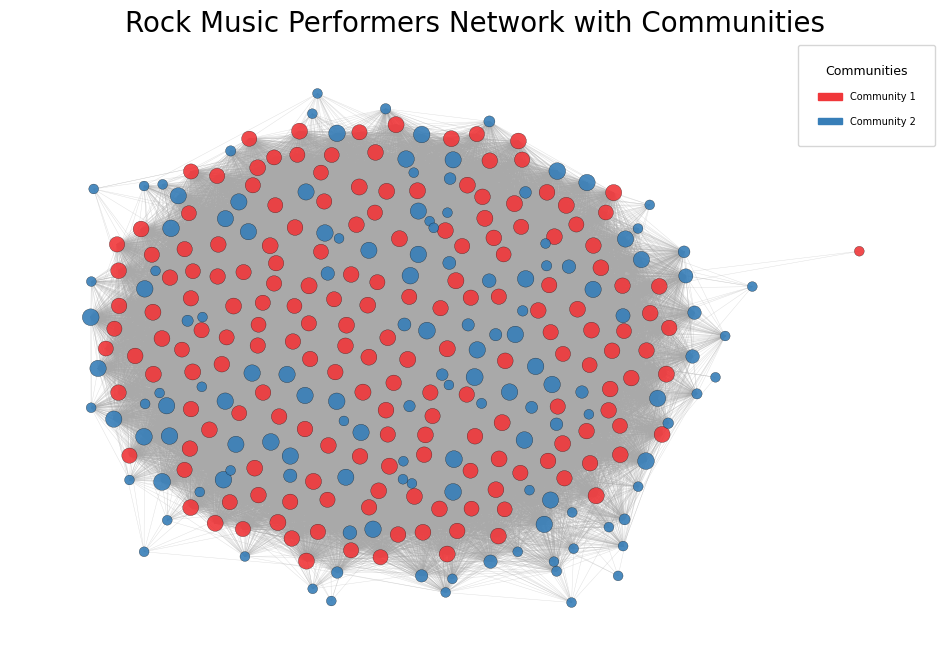

In [163]:

pos = nx.drawing.forceatlas2_layout(G_undirected)

def draw_graph_with_communities(G_undirected, pos, list_communities_louvain, title="Rock Music Performers Network with Communities"):

    # Sort communities by size and keep all communities because they are a few
    partition_sorted = sorted(list_communities_louvain, key=len, reverse=True)
    top_communities = partition_sorted

    # Manage node sizes based on degree
    deg_dict = dict(G_undirected.degree())
    node_sizes = [max(50, d*0.5) for d in deg_dict.values()] 

    # Create a mapping from node to community index
    node_to_comm = {}
    for idx, comm in enumerate(top_communities):
        for node in comm:
            node_to_comm[node] = idx

    # Prepare colormap
    n_colors = max(1, len(top_communities))
    custom_colors = [
        "#f0373a",  
        "#377eb8",  
        "#4daf4a", 
        "#984ea3",  
        "#fba34c",  
        "#fbfb50",  
    ]

    # Buils a node color list based on community membership
    node_colors = []
    for node in G_undirected.nodes():
        comm = node_to_comm.get(node)
        if comm is not None and comm < len(custom_colors):
            node_colors.append(custom_colors[comm])
        else:
            node_colors.append("#d3d3d3")
            

    # Create legend entries for each community color
    legend_patches = [
        mpatches.Patch(color=custom_colors[i], label=f"Community {i + 1}")
        for i in range(len(top_communities))
    ]

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G_undirected, pos, node_color=node_colors, node_size=node_sizes, linewidths=0.2, edgecolors='black', alpha=0.9)
    nx.draw_networkx_edges(G_undirected, pos, alpha=0.4, width=0.3, edge_color="#a9a9a9")
    plt.legend(
        handles=legend_patches, 
        title="Communities", 
        fontsize=7,  # Larger font for legend items
        title_fontsize=9,  # Larger font for legend title
        loc='upper right', 
        markerscale=2,  # Increase marker scale for better visibility
        borderpad=2,  # Increase padding inside the legend box
        labelspacing=1.5,  # Increase space between legend items
        handlelength=2.5  # Increase length of color patches
    )
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

draw_graph_with_communities(G_undirected, pos, list_communities_louvain)



Backboning Test

In [164]:

#Model 2
def backboning_graph(G, alpha_thresh):
    # Make sure the graph is undirected
    G_undirected = G.copy() 
    
    edge_betweenness = nx.edge_betweenness_centrality(G_undirected, normalized=False)
    normalized_weights = 1 + (np.array(list(edge_betweenness.values())) - min(edge_betweenness.values())) * (99 / (max(edge_betweenness.values()) - min(edge_betweenness.values())))
    # get edges
    edges = list(G_undirected.edges())

    # build the weights dictionary
    normalized_weights_dict = {
    edge: float(normalized_weights[i]) for i, edge in enumerate(edges)
        }

    # assign weights to edges
    nx.set_edge_attributes(G_undirected, normalized_weights_dict, "weight")

    # Suppose that your graph is G with weights 'weight'
    edges_data = [(u, v, w['weight'], w.get('common_subtopics', [])) for u, v, w in G_undirected.edges(data=True)]

    df_edges = pd.DataFrame(edges_data, columns=['src', 'trg', 'nij', 'common_subtopics'])

    # Apply the disparity filter
    df_backbone = backboning.disparity_filter(df_edges[['src', 'trg', 'nij']], undirected=True)
    df_backbone_filtered = df_backbone[df_backbone["score"] < alpha_thresh]


    # To reconstruct a graph from the backbone
    G_backbone = nx.Graph()
    
    for _, row in df_backbone_filtered.iterrows():
        common_subtopics = df_edges.loc[
            (df_edges['src'] == row['src']) & (df_edges['trg'] == row['trg']),
            'common_subtopics'
        ].values[0]
        
        G_backbone.add_edge(
            row['src'], row['trg'], weight=row['nij'], score=row['score'], common_subtopics=common_subtopics
        )
    

    return G_backbone

# Apply backboning with a chosen alpha threshold
alpha_threshold = 0.50
G_backbone = backboning_graph(G_undirected, alpha_threshold)
print("Original number of edges:", G_undirected.number_of_edges())
print("Number of edges in backbone:", G_backbone.number_of_edges())
print("Number of nodes in backbone:", G_backbone.number_of_nodes())

Calculating DF score...


Original number of edges: 34483
Number of edges in backbone: 871
Number of nodes in backbone: 259


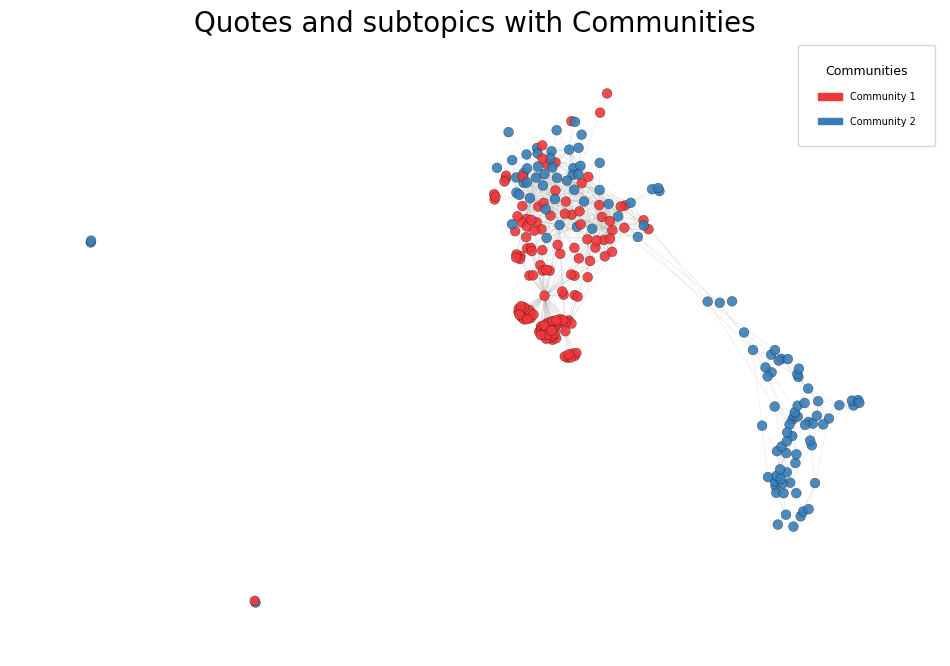

In [165]:
pos_backbone = nx.drawing.forceatlas2_layout(G_backbone, seed=42)
draw_graph_with_communities(G_backbone, pos_backbone, list_communities_louvain,title="Quotes and subtopics with Communities")

### TF-IDF on communities

In [175]:
n_communities = len(list_communities_louvain)

for community_id in range(n_communities):
    nodes_in_community = list_communities_louvain[community_id]

    for node in nodes_in_community:
        G_undirected.nodes[node]["community"] = community_id


In [203]:
from collections import Counter

dict_subtopics_by_communities = {
    'Community_' + str(i): Counter() for i in range(n_communities)
}

for node in G_undirected.nodes():
    community_id = G_undirected.nodes[node].get("community")
    subtopics = G_undirected.nodes[node].get("subtopics", []) 

    dict_subtopics_by_communities['Community_' + str(community_id)].update(subtopics)


# Si tu veux transformer le Counter en dict classique
dict_subtopics_by_communities_sorted = {
    comm: dict(sorted(counter.items(), key=lambda x: x[1], reverse=True))
    for comm, counter in dict_subtopics_by_communities.items()
}

In [205]:
def calculate_idf(genres_data, total_documents):
    
    # Count number of documents containing each word
    document_frequency = defaultdict(int)
    for wikipage, entry in genres_data.items():
        for word, data in entry.items():
            document_frequency[word] += 1

    # Calculate IDF for each word in each wikipage
    idf_data = {}
    for wikipage, entry in genres_data.items():
        idf_dict = {}
        for word in entry.keys():
            df = document_frequency[word]
            # +1 to avoid division by zero (even if not necessary here)
            idf = np.log(total_documents / (df))  
            idf_dict[word] = idf
        idf_data[wikipage] = idf_dict

    return idf_data


In [212]:
def compute_tfidf(genres_data, idf_data):
    tfidf_by_wikiquote_page = {}
    for wikipage, entry in genres_data.items():
        tfidf_dict = {}
        sum_subtopics = sum(data for data in entry.values())
        print(f"Sum of subtopics frequencies for {wikipage}: {sum_subtopics}")
        for word, data in entry.items():

            tf = data/sum_subtopics
            idf = idf_data[wikipage].get(word, 0)
            tfidf = tf * idf
            tfidf_dict[word] = tfidf
        tfidf_by_wikiquote_page[wikipage] = tfidf_dict
    return tfidf_by_wikiquote_page

idf_data = calculate_idf(dict_subtopics_by_communities_sorted, n_communities)
tfidf_data = compute_tfidf(dict_subtopics_by_communities_sorted, idf_data)

Sum of subtopics frequencies for Community_0: 1538
Sum of subtopics frequencies for Community_1: 2422


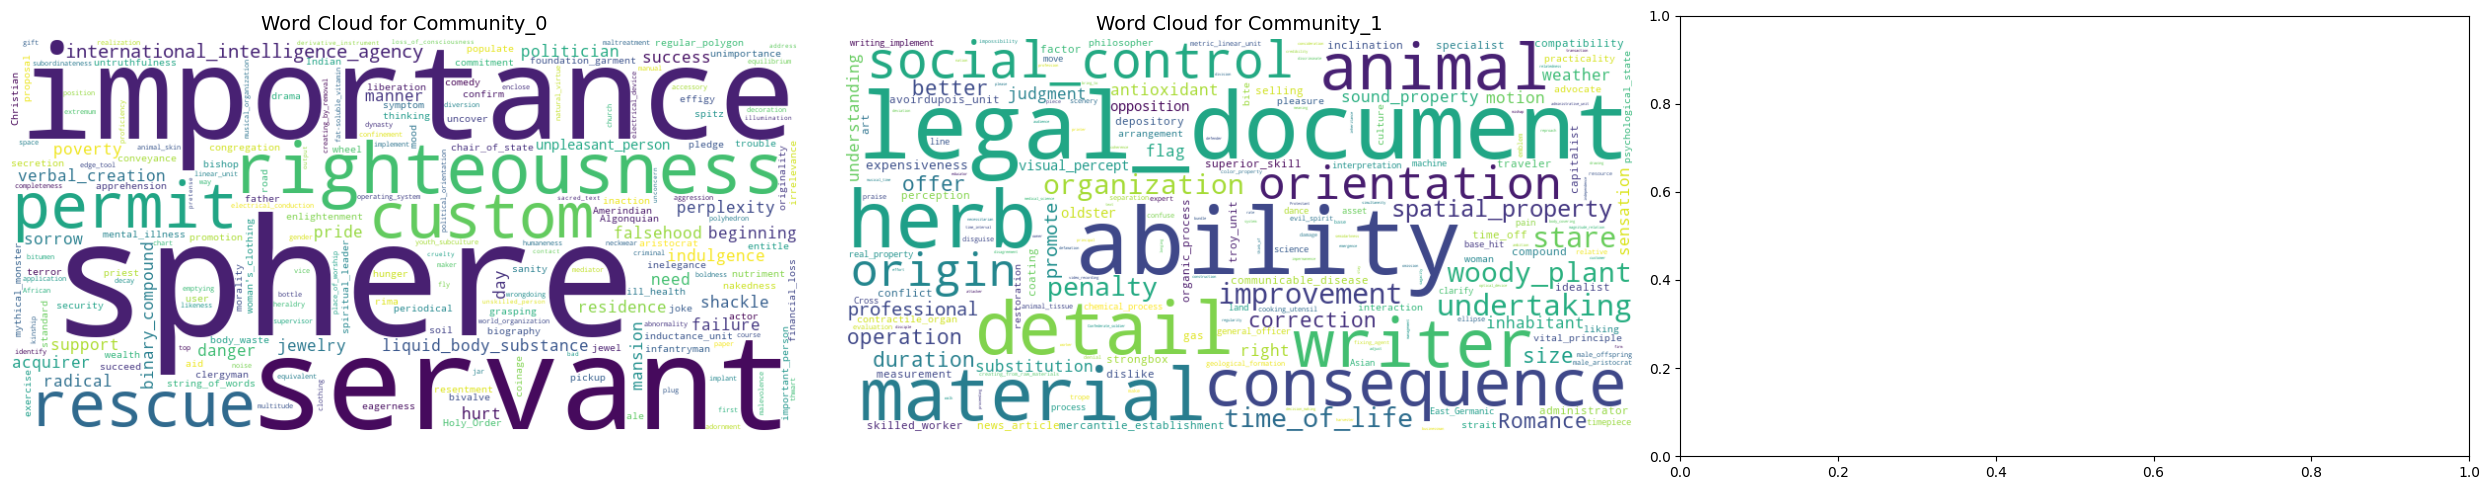

In [214]:
def plot_wordcloud_for_tfidf(top_genres, tfidf_data, number_rows=1, number_cols=3):

    fig, axes = plt.subplots(number_rows, number_cols, figsize=(25, number_rows * 5))
    axes = axes.flatten()
    
    for i, genre in enumerate(top_genres):
        # Generate word cloud
        wc = WordCloud(width=800, height=400, background_color='white', colormap='viridis', mask=None, collocations=False, random_state=42)
        wc.generate_from_frequencies(tfidf_data[genre])

        # Plot word cloud
        ax = axes[i]
        ax.imshow(wc, interpolation="bilinear")
        ax.set_title(f"Word Cloud for {genre}", fontsize=14)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

top_wikipages = list(dict_subtopics_by_communities_sorted.keys())
plot_wordcloud_for_tfidf(top_wikipages, tfidf_data)

Wordcloud shows the difference of concept around the subject between our communities